In [1]:
import numpy as np
import pandas as pd
from IPython.display import display
import pylab

In [2]:
# Функции
def u(x, t):
    return x**2 + t**2


def f(x, t):
    return 2 * t - 2


# Координаты
def x_i(a, i, h):
    return a + i * h


def t_j(j, tau):
    return j * tau

In [3]:
# Представление числа в экспоненциальной форме
def exp_form(a):
    return '%e' % a


# Округление числа a до n-го знака
def discard(a, n):
    return ('{0:.' + str(n) + 'f}').format(a).rstrip('0').rstrip('.')


# Инициализация определённых узлов сетки НУ и ГУ условиями
def init_y(m, n, a, tau, h):
    y = np.empty((m, n))

    # Начальные условия
    for i in range(n):
        y[0][i] = u(x_i(a, i, h), 0)

    # Граничные условия
    for j in range(1, m):
        y[j][0] = u(a, t_j(j, tau))
        y[j][-1] = u(b, t_j(j, tau))

    return y


# Решение 3-хдиагональной СЛАУ методом прогонки
def tridiagonal_matrix_algorithm(a, b, c, d):
    n = len(a)

    if a[0] != 0:
        raise Exception('Ошибка: a[0] должно быть = 0!')

    if c[n - 1] != 0:
        raise Exception('Ошибка: c[n - 1] должно быть = 0!')

    alpha = np.zeros((n))
    beta = np.zeros((n))
    x = np.zeros((n))

    for i in range(1, n):
        alpha[i] = -c[i - 1] / (a[i - 1] * alpha[i - 1] + b[i - 1])
        beta[i] = (d[i - 1] - a[i - 1] * beta[i - 1]) / (
            a[i - 1] * alpha[i - 1] + b[i - 1])

    x[n - 1] = (d[n - 1] - a[n - 1] * beta[n - 1]) / (a[n - 1] * alpha[n - 1] +
                                                      b[n - 1])

    for i in range(n - 2, -1, -1):
        x[i] = alpha[i + 1] * x[i + 1] + beta[i + 1]

    return x


# Явная разностная схема
def explicit_difference_scheme(a, b, T, tau, h):
    #     if not (tau / (h ** 2) <= 1 / 2):
    #         raise Exception('Не выполняется условие устойчивости явной схемы!\nДолжно быть: tau / h^2 <= 1 / 2')

    m = int(T / tau) + 1
    n = int((b - a) / h) + 1
    y = init_y(m, n, a, tau, h)

    for j in range(m - 1):
        for i in range(1, n - 1):
            y[j +
              1][i] = tau * ((y[j][i + 1] - 2 * y[j][i] + y[j][i - 1]) /
                             (h**2) + f(x_i(a, i, h), t_j(j, tau))) + y[j][i]

    return y


# Весовая схема
def weighting_difference_scheme(a, b, T, tau, h, sigma=1 / 2):
    # Значение правой части уравнения, приведённого к виду, удобному для использования метода прогонки
    def right_side(j, i):
        # Схема Кранка-Николсона
        if sigma == 1 / 2:
            t = t_j(j + 1 / 2, tau)
        # Неявная схема
        elif sigma == 1:
            t = t_j(j + 1, tau)
        # Обычная весовая
        else:
            t = t_j(j, tau)

        return y[j][i] + tau * ((1 - sigma) *
                                (y[j][i - 1] - 2 * y[j][i] + y[j][i + 1]) /
                                (h**2) + f(x_i(a, i, h), t))

#     if not (1 / 2 <= sigma <= 1):
#         raise Exception('Не выполняется условие устойчивости весовой схемы!\nДолжно быть: 1 / 2 <= sigma <= 1')

    m = int(T / tau) + 1
    n = int((b - a) / h) + 1
    y = init_y(m, n, a, tau, h)

    for j in range(m - 1):
        size = n - 2
        a_coeff = np.full((size), (-sigma * tau) / (h**2))
        b_coeff = np.full((size), 1 + (2 * sigma * tau) / (h**2))
        c_coeff = np.copy(a_coeff)
        d_coeff = np.array([right_side(j, i) for i in range(1, n - 1)])
        d_coeff[0] = d_coeff[0] - a_coeff[0] * y[j + 1][0]
        d_coeff[-1] = d_coeff[-1] - c_coeff[-1] * y[j + 1][-1]
        a_coeff[0] = c_coeff[-1] = 0

        y_x = tridiagonal_matrix_algorithm(a_coeff, b_coeff, c_coeff, d_coeff)

        for i in range(len(y_x)):
            y[j + 1][i + 1] = y_x[i]

    return y


# Схема Кранка-Николсона
def crank_nicolson_scheme(a, b, T, tau, h):
    return weighting_difference_scheme(a, b, T, tau, h, sigma=1 / 2)


# Неявная схема
def implicit_difference_scheme(a, b, T, tau, h):
    return weighting_difference_scheme(a, b, T, tau, h, sigma=1)


# Вычисление максимальной ошибки
def get_max_error(y, a, tau, h):
    m, n = y.shape
    max_error = 0

    for j in range(m):
        for i in range(n):
            max_error = max(max_error,
                            abs(y[j][i] - u(x_i(a, i, h), t_j(j, tau))))

    return max_error


# Исследование устойчивости явной схемы
def analyze_eds(a, b, T):
    table = pd.DataFrame([], columns=['Максимальная абсолютная погрешность'])
    table.columns.name = 'τ'
    h = 1e-1

    print('Исследование устойчивости явной схемы')
    print('h = 1e-1')

    for e in range(5, 0, -1):
        tau = 10**(-e)
        eds = explicit_difference_scheme(a, b, T, tau, h)
        table.loc['1e-' + str(e)] = [exp_form(get_max_error(eds, a, tau, h))]

    display(table)


# Исследование устойчивости неявной схемы
def analyze_ids(a, b, T):
    table = pd.DataFrame([], columns=['Максимальная абсолютная погрешность'])
    table.columns.name = 'τ'
    h = 1e-1

    print('Исследование устойчивости неявной схемы')
    print('h = 1e-1')

    for e in range(5, 0, -1):
        tau = 10**(-e)
        ids = implicit_difference_scheme(a, b, T, tau, h)
        table.loc['1e-' + str(e)] = [exp_form(get_max_error(ids, a, tau, h))]

    display(table)


# Исследование устойчивости весовой схемы
def analyze_wds(a, b, T):
    table = pd.DataFrame([], columns=['Максимальная абсолютная погрешность'])
    table.columns.name = 'σ'
    tau = h = 1e-2

    print('Исследование устойчивости весовой схемы')
    print('τ = h = 1e-2')

    for s in range(1, 11):
        sigma = s * 1e-1
        wds = weighting_difference_scheme(a, b, T, tau, h, sigma)
        table.loc[discard(sigma,
                          1)] = [exp_form(get_max_error(wds, a, tau, h))]
        
        if s == 5:
            fig = pylab.figure()
            ax = fig.gca(projection='3d')
            m = int(T / tau) + 1
            n = int((b - a) / h) + 1

            X = np.array([x_i(a, i, h) for i in range(n)])
            Y = np.array([t_j(j, tau) for j in range(m)])
            X, Y = np.meshgrid(X, Y)
            Z = wds

            ax.text2D(0.05, 0.95, '$%s$' % r'u(x,t)=x^2+t^2', fontsize=20, transform=ax.transAxes)
            ax.set_xlabel('x', fontsize=20)
            ax.set_ylabel('t', fontsize=20)
            ax.set_zlabel('$%s$' % r'{y_{i}}^{j}', fontsize=20)
            ax.plot_surface(X, Y, Z, cmap='inferno')

    display(table)

Исследование устойчивости явной схемы
h = 1e-1


τ,Максимальная абсолютная погрешность
1e-5,9.952199e-06
1e-4,9.952354e-05
1e-3,9.953756e-04
1e-2,1.109713e+88
1e-1,2.055790e+26


Исследование устойчивости неявной схемы
h = 1e-1


τ,Максимальная абсолютная погрешность
1e-5,9.952142e-06
1e-4,9.952043e-05
1e-3,9.950640e-04
1e-2,9.936640e-03
1e-1,9.798489e-02


Исследование устойчивости весовой схемы
τ = h = 1e-2


σ,Максимальная абсолютная погрешность
0.1,3.353611e+180
0.2,2.133223e+111
0.3,9.407161e+64
0.4,6.187387e+26
0.5,1.397105e-12
0.6,9.951682e-03
0.7,9.948566e-03
0.8,9.945449e-03
0.9,9.942332e-03
1,9.939213e-03


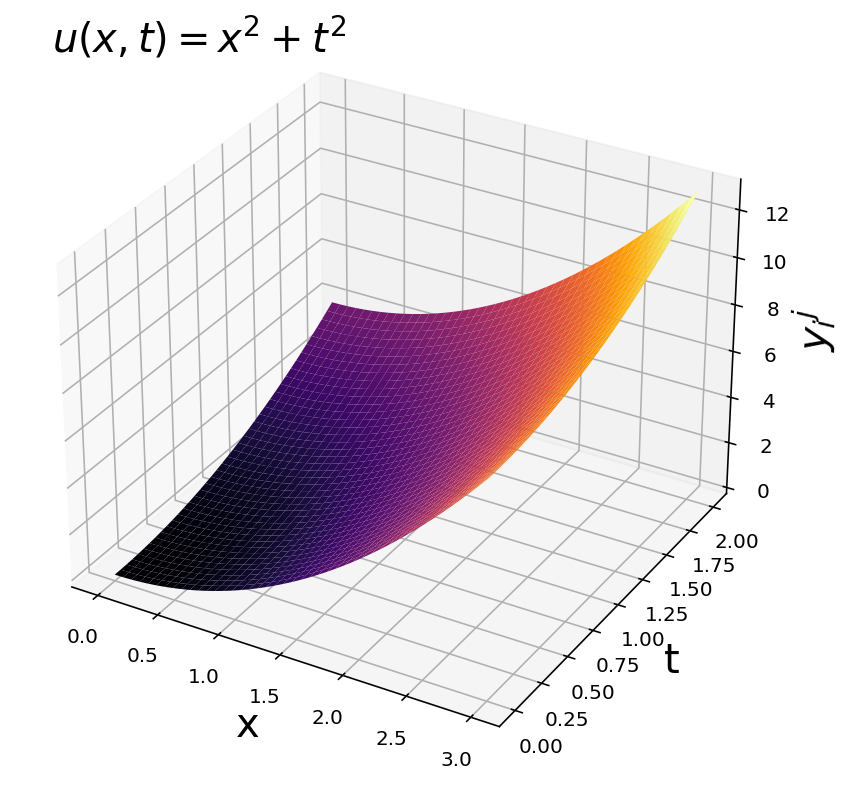

In [4]:
a, b = 0, 3
T = 2

analyze_eds(a, b, T)
analyze_ids(a, b, T)
analyze_wds(a, b, T)